# VAE TO GENERATE MNIST
https://github.com/FelixMohr/Deep-learning-with-Python/blob/master/VAE.ipynb

import data

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('..\data\MNIST_data')

Extracting ..\data\MNIST_data/train-images-idx3-ubyte.gz
Extracting ..\data\MNIST_data/train-labels-idx1-ubyte.gz
Extracting ..\data\MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ..\data\MNIST_data/t10k-labels-idx1-ubyte.gz


# VAE 1.0

## placeholders

In [3]:
tf.reset_default_graph()
batch_size = 64
# placeholders
# X_ph = tf.placeholder(
#             dtype = tf.float32,
#             shape = [None, 28, 28, 1],
#             name = "conv_in"
#         )
# Y_ph = tf.placeholder(dtype=tf.float32,
#                       shape = [None, 28, 28, 1],
#                       name = 'Y')

# Y_flat_ph = tf.reshape(Y_ph, shape = [-1, 28*28])

# keep_prob_ph = tf.placeholder(dtype = tf.float32,
#                               shape = (),
#                               name = 'keep_prob')
dec_in_channels = 1
n_latent = 8
reshaped_dim = [-1,7,7,dec_in_channels]
inputs_decoder = int(49*dec_in_channels/2)

def lrelu(x, alpha = 0.03):
    return tf.maximum(x, tf.multiply(x, alpha))

## encoder
image to mean and stddev

In [4]:
tf.reset_default_graph()
def encoder(in_sample,keep_prob = 1,tracking = False):
    if tracking:
        X_in = tf.placeholder(
            dtype = tf.float32,
            shape = [None, 28, 28, 1],
            name = "conv_in"
        )
    else:
        X_in = in_sample
    activation = lrelu
    with tf.variable_scope("encoder",reuse = None):
        X = tf.reshape(X_in, shape = [-1, 28, 28, 1])  # [3,28,28,1]
        conv1 = tf.layers.conv2d(X,                    # [3,14,14,64]
                             filters = 64,
                             kernel_size = 4,
                             strides = 2,
                             padding = 'same',
                             activation = activation
                            )
        dropout1 = tf.nn.dropout(conv1, keep_prob)
        conv2 = tf.layers.conv2d(dropout1,             # [3,7,7,64]
                     filters = 64,
                     kernel_size = 4,
                     strides = 2,
                     padding = 'same',
                     activation = activation
                    )
        dropout2 = tf.nn.dropout(conv2, keep_prob)     
        conv3 = tf.layers.conv2d(dropout2,             # [3,7,7,64]
                     filters = 64,
                     kernel_size = 4,
                     strides = 1,
                     padding = 'same',
                     activation = activation
                    )
        dropout3 = tf.nn.dropout(conv3, keep_prob)
        flatten = tf.contrib.layers.flatten(dropout3)  # [3,3136]
        mn = tf.layers.dense(flatten, units = n_latent)                        # [3,8]
        epsilon = tf.random_normal(tf.stack([tf.shape(flatten)[0], n_latent])) # [3,8]
        sd = .5*tf.layers.dense(flatten, units = n_latent)                     # [3,8]
        z = mn+tf.multiply(epsilon,tf.exp(sd))                                 # [3,8]
        if tracking:
            config = tf.ConfigProto()
            config.gpu_options.allow_growth=True
            sess = tf.Session(config=config)
            sess.run(tf.global_variables_initializer())
            return sess.run(epsilon, feed_dict =
                            {X_in: in_sample})
        return z,mn,sd

image_sample = np.ones((3,28,28,1))
print(encoder(image_sample,1,True).shape)


(3, 8)


# decoder

In [5]:
tf.reset_default_graph()
def decoder(sampled_z_in, keep_prob,tracking = False):
    activation = lrelu
    if tracking:
         sampled_z = tf.placeholder(
             dtype = tf.float32,
             shape = [None, 8],
             name = "conv_in"
         )
    else:
        sampled_z = sampled_z_in
    with tf.variable_scope("decoder", reuse = None):
        x = tf.layers.dense(sampled_z, units = inputs_decoder, activation = lrelu) # [3,24]
        x2 = tf.layers.dense(x, units = inputs_decoder*2+1, activation = lrelu)    # [3,49]
        unflatten = tf.reshape(x2, reshaped_dim)                                   # [3,7,7,1]
        deconv_3 = tf.layers.conv2d_transpose(unflatten,                           # [3,7,7,64]
                                              filters = 64,
                                              kernel_size = 4,
                                              strides = 1,
                                              padding = 'same'
                                             )
        dropout_3 = tf.nn.dropout(deconv_3, keep_prob)
        deconv_2 = tf.layers.conv2d_transpose(dropout_3,                           # [3,14,14,64]
                                              filters = 64,
                                              kernel_size = 4,
                                              strides = 2,
                                              padding = 'same'
                                             )
        dropout_2 = tf.nn.dropout(deconv_2, keep_prob)
        deconv_1 = tf.layers.conv2d_transpose(dropout_2,                           # [3,28,28,64]
                                              filters = 64,
                                              kernel_size = 4,
                                              strides = 2,
                                              padding = 'same'
                                             )
        dropout_1 = tf.nn.dropout(deconv_1, keep_prob)                             # [3,50176]
        flatten = tf.contrib.layers.flatten(dropout_1)
        decode_out = tf.layers.dense(flatten, units = 28*28, activation = tf.nn.sigmoid) # [3,784]
        img = tf.reshape(decode_out, shape = [-1,28,28,1])                         # [3,28,28,1]
        if tracking:
            config = tf.ConfigProto()
            config.gpu_options.allow_growth=True
            sess = tf.Session(config=config)
            sess.run(tf.global_variables_initializer())
            return sess.run(img, feed_dict =
                            {sampled_z: sampled_z_in})
        return img
sample_z = np.ones((3,8))
print(decoder(sample_z,1,True).shape)

(3, 28, 28, 1)


## define & compute loss function
loss = combineation of KL divergence &  squared difference

In [ ]:
# tf.reset_default_graph()
with tf.variable_scope("loss", reuse = None):
    X_ph = tf.placeholder(
                dtype = tf.float32,
                shape = [None, 28, 28, 1],
                name = "X_ph"
            )
    keep_prob_ph = tf.placeholder(dtype = tf.float32,
                                  shape = (),
                                  name = 'keep_prob_ph'
                                 )
    Y_ph = tf.placeholder(dtype=tf.float32,
                      shape = [None, 28, 28, 1],
                      name = 'Y')

    Y_flat_ph = tf.reshape(Y_ph, shape = [-1, 28*28])
    sampled, mn, sd = encoder(X_ph, keep_prob_ph)
    dec = decoder(sampled, keep_prob_ph)

unreshaped = tf.reshape(dec, [-1,28*28])
# Y_flat_ph
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat_ph), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - mn**2 - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss+latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

## Train

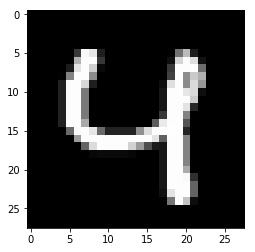

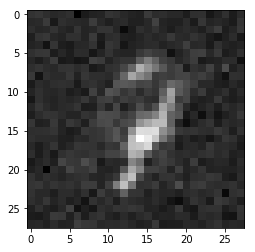

0 165.04 165.038 0.00160907


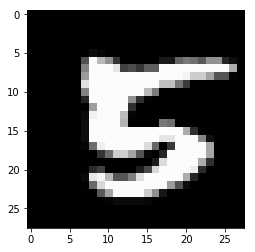

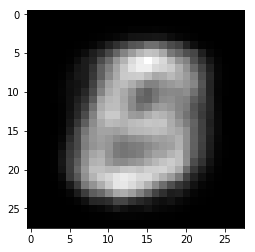

200 49.1353 47.3717 1.76364


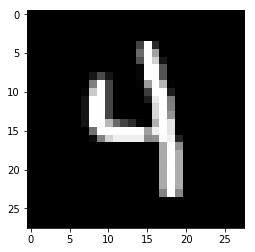

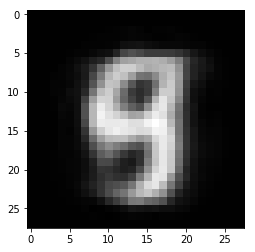

400 38.5066 32.7037 5.80283


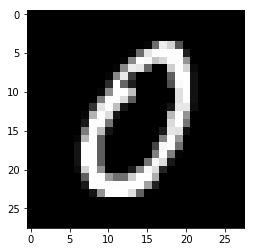

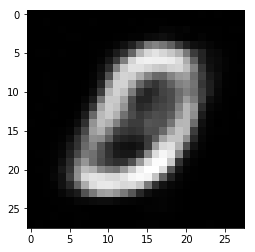

600 35.6228 27.6372 7.98562


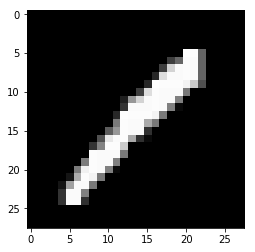

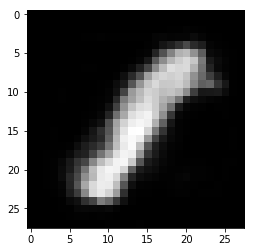

800 34.8862 27.4087 7.47748


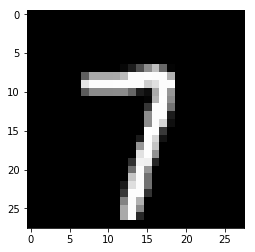

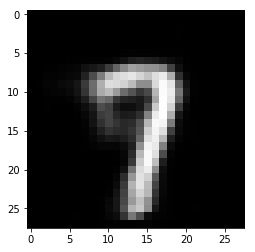

1000 34.1433 26.3789 7.76441


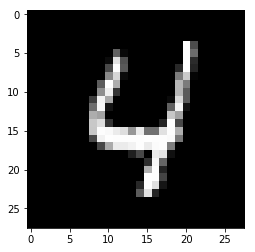

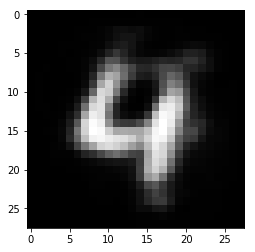

1200 35.0565 26.547 8.50942


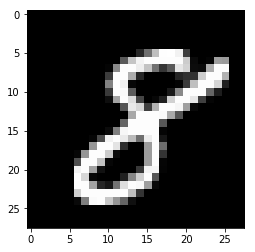

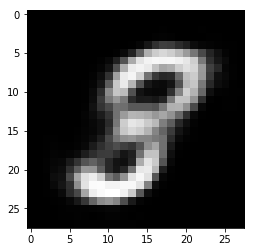

1400 33.4276 25.1591 8.26856


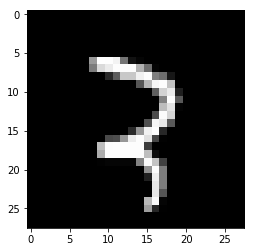

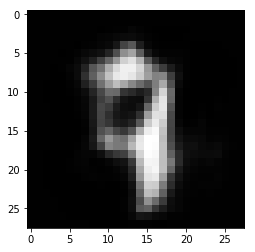

1600 33.8506 25.3554 8.49523


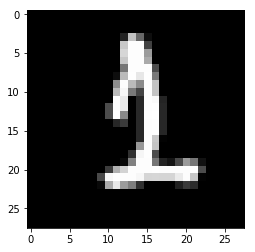

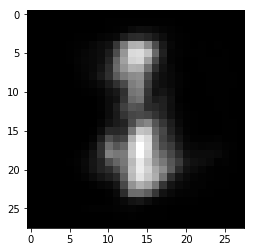

1800 33.5335 25.2024 8.33115


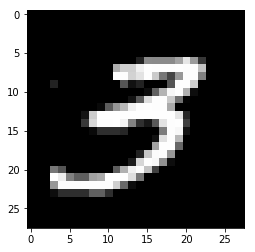

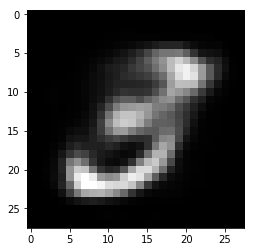

2000 34.6979 26.3343 8.36354


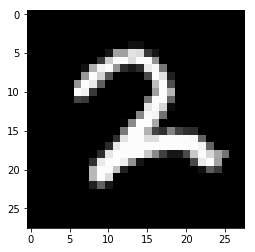

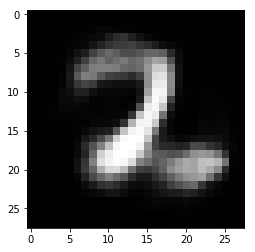

2200 34.5849 26.0253 8.55961


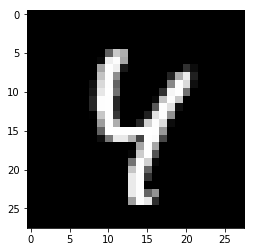

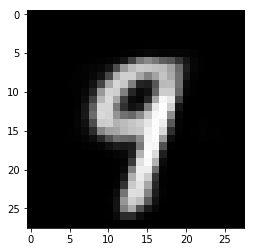

2400 32.2428 24.0761 8.16675


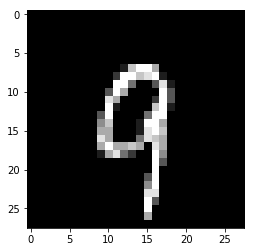

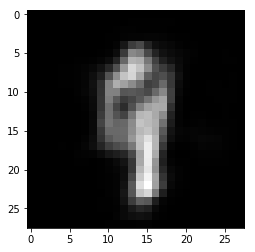

2600 34.3082 25.9316 8.37659


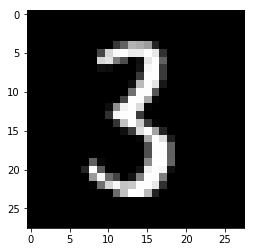

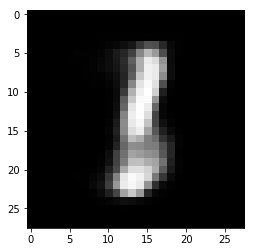

2800 35.1613 25.997 9.16436


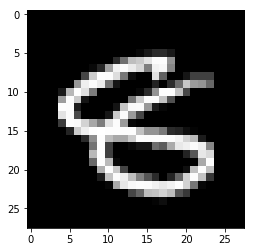

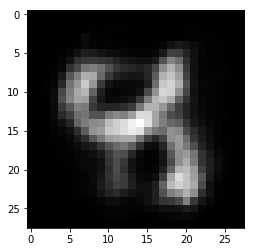

3000 33.5718 25.5229 8.04893


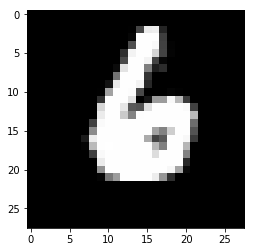

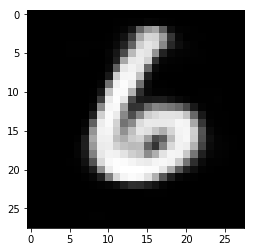

3200 33.4643 24.5675 8.89677


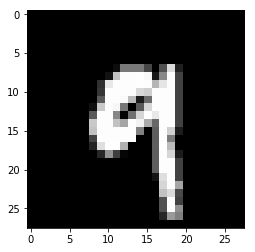

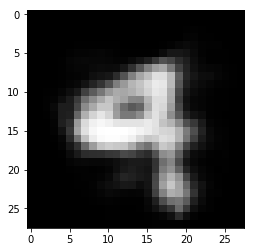

3400 34.6341 25.7759 8.85825


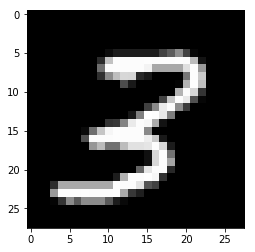

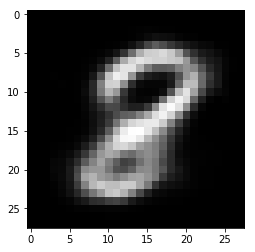

3600 33.8118 25.9076 7.90419


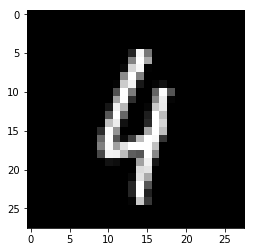

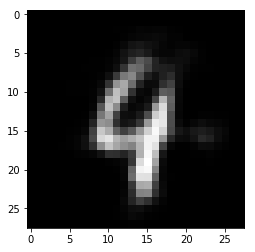

3800 33.3665 24.6053 8.76124


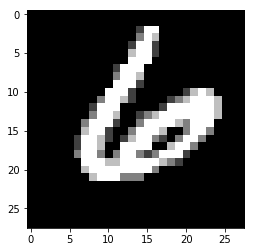

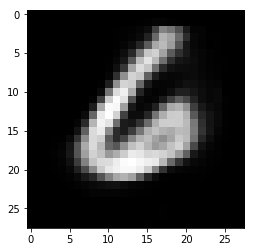

4000 31.3839 22.9305 8.4534


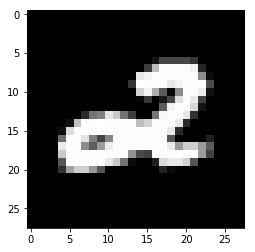

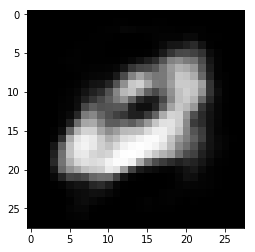

4200 31.7981 23.0859 8.7122


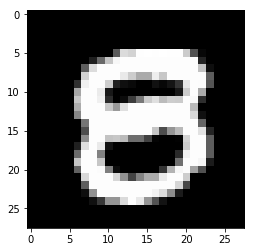

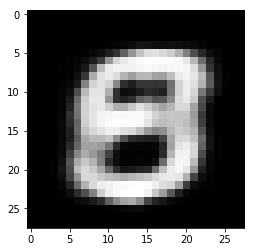

4400 35.2887 26.3346 8.95418


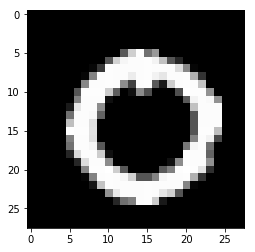

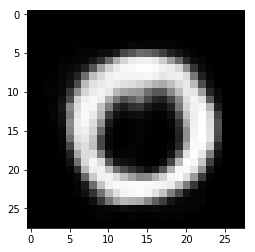

4600 33.2083 24.3661 8.84214


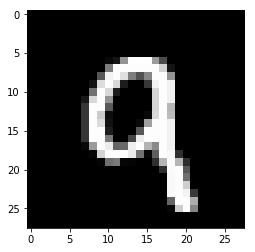

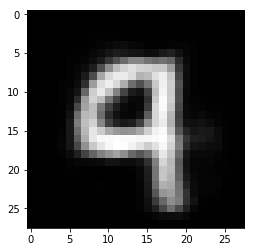

4800 33.707 24.8026 8.90434


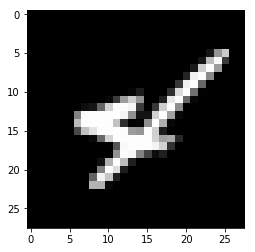

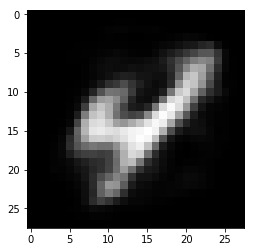

5000 32.6446 24.103 8.54165


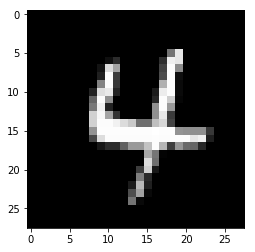

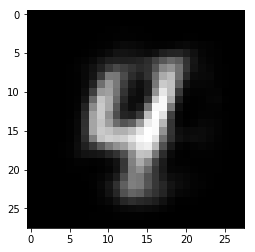

5200 32.3479 24.1802 8.1677


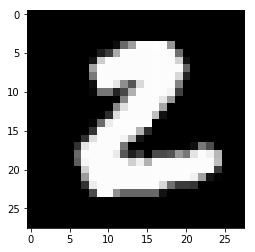

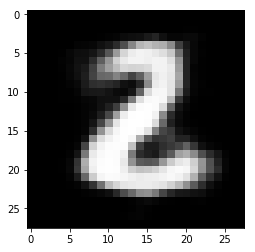

5400 32.0594 23.4279 8.63148


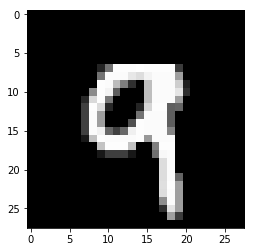

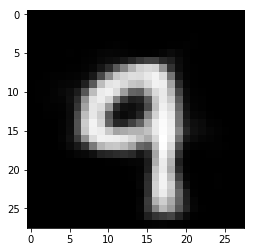

5600 33.3792 24.1589 9.22037


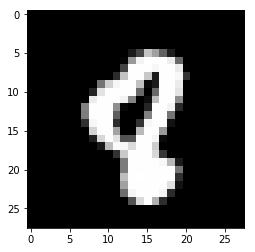

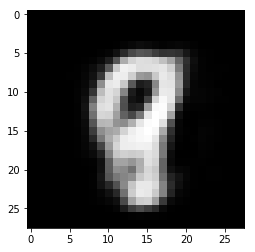

5800 28.9409 20.3622 8.57872


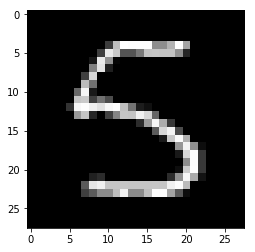

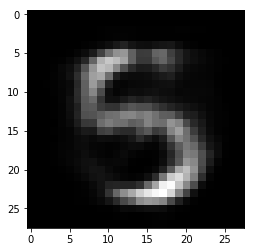

6000 31.458 22.8826 8.57539


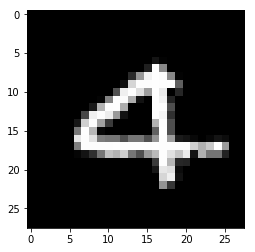

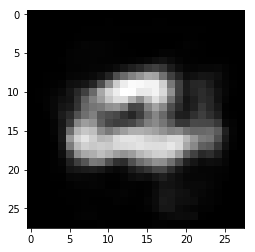

6200 31.9002 22.9965 8.90368


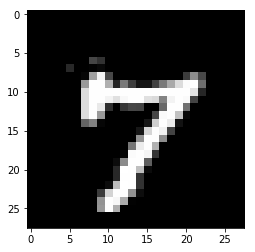

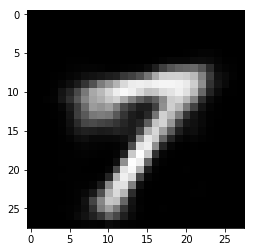

6400 31.0434 22.4311 8.61226


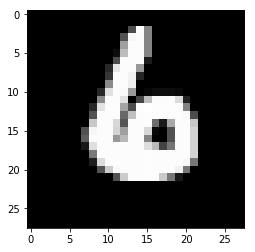

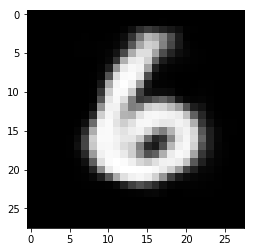

6600 30.8381 21.5297 9.30834


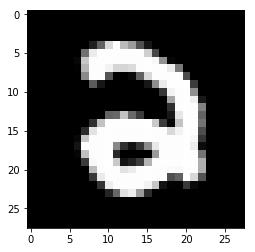

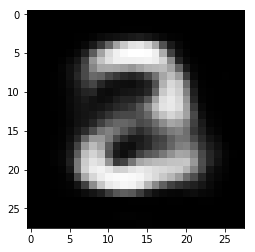

6800 33.3163 24.8436 8.47267


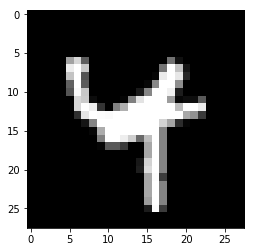

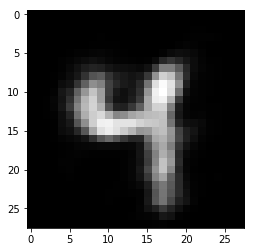

7000 34.0871 24.4676 9.61944


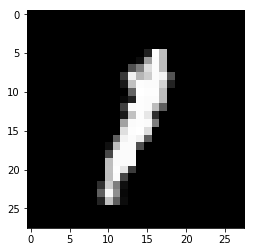

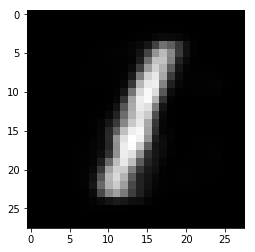

7200 30.8837 22.094 8.78975


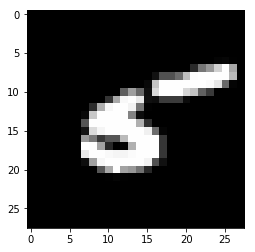

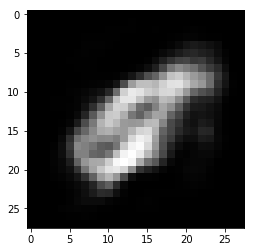

7400 30.4784 21.5428 8.93569


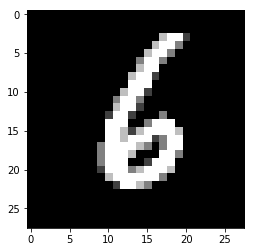

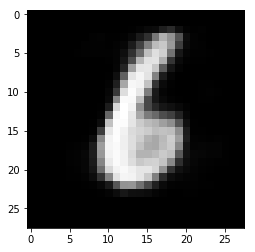

7600 34.6095 25.4681 9.14138


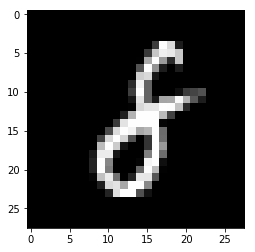

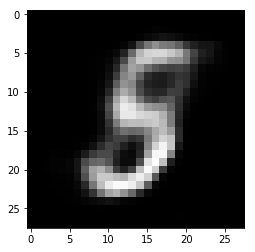

7800 33.9139 24.5892 9.32465


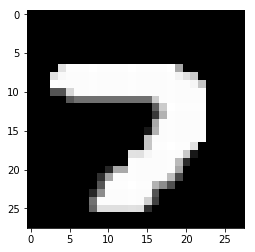

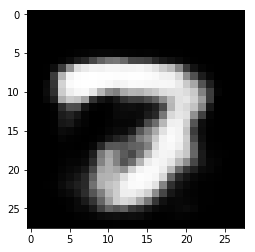

8000 30.79 21.3414 9.44859


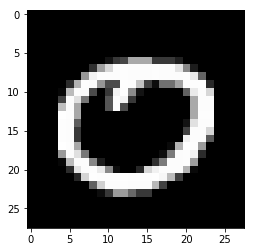

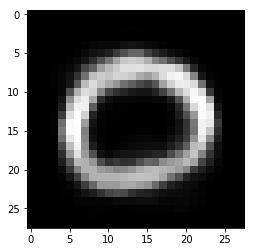

8200 32.2537 22.9168 9.33694


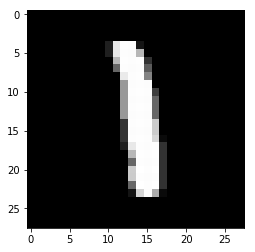

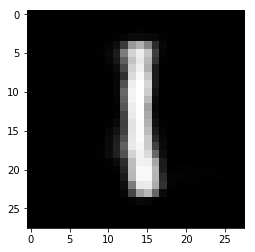

8400 31.6028 22.3013 9.30148


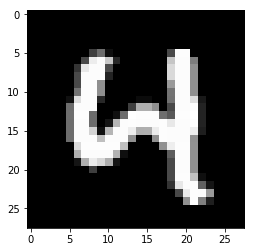

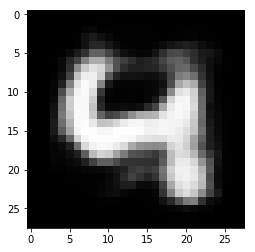

8600 32.0563 22.5134 9.54284


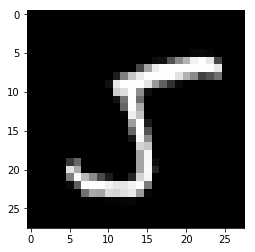

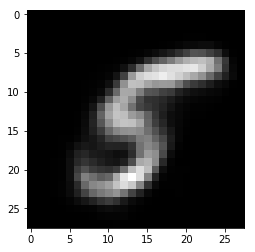

8800 32.4877 22.9723 9.51532


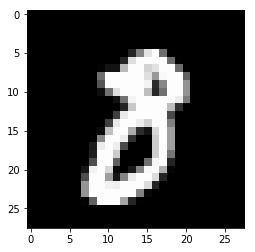

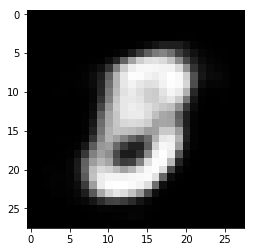

9000 32.7745 23.6636 9.11089


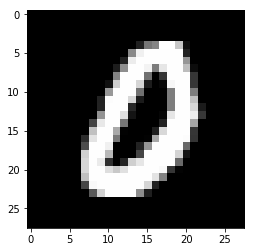

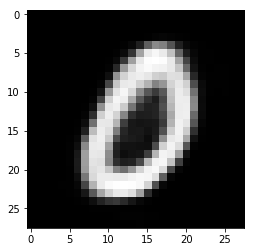

9200 32.4705 23.1498 9.3207


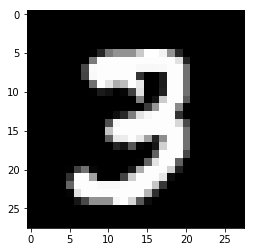

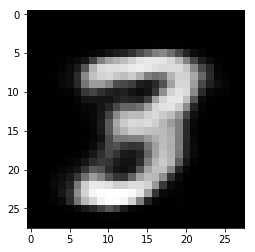

11200 29.2589 20.6428 8.61616


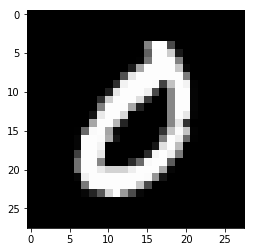

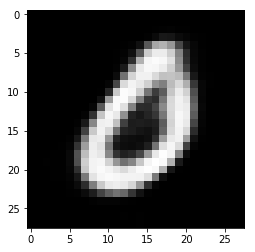

11400 30.9309 21.5804 9.35056


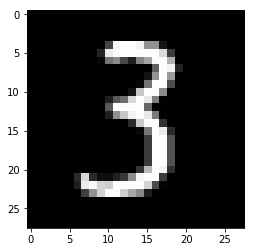

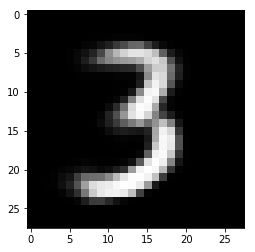

11600 30.1761 21.429 8.74711


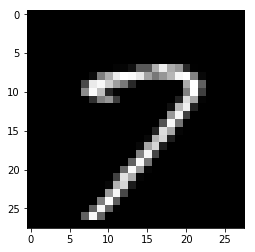

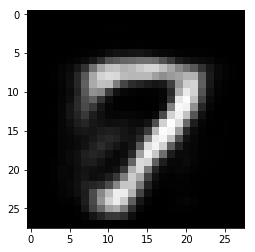

11800 28.5981 19.5658 9.03234


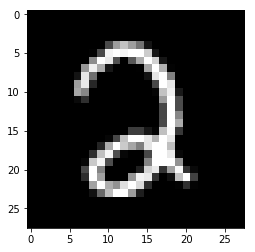

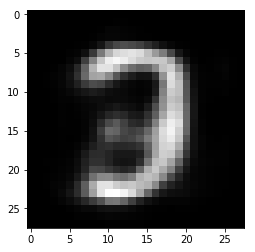

12000 31.4784 22.0848 9.39354


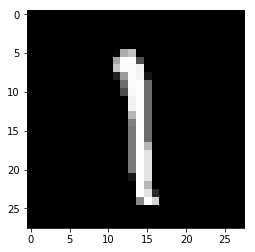

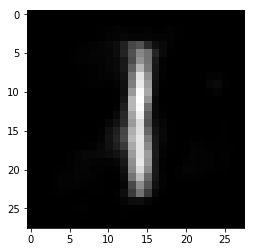

12200 33.0915 23.3156 9.7759


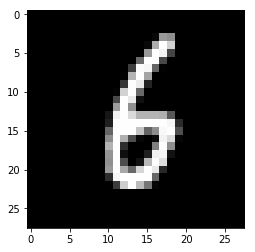

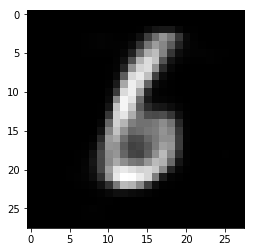

12400 30.8121 21.6 9.21205


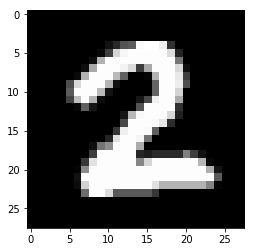

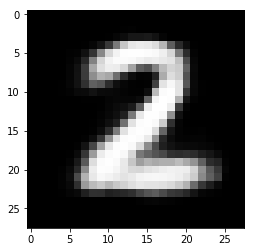

12600 30.3507 21.4222 8.92859


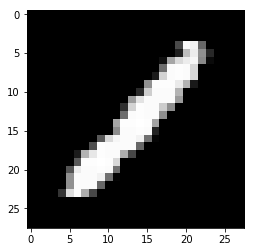

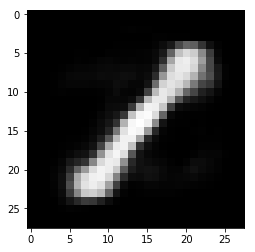

12800 31.9948 22.9395 9.0553


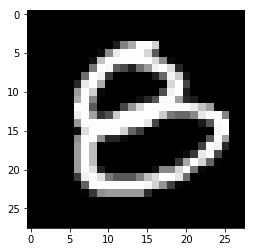

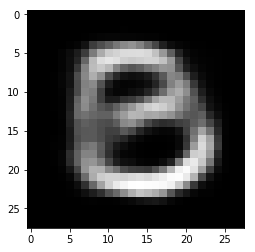

13000 33.6251 24.3257 9.29943


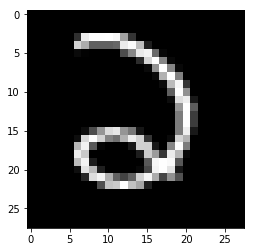

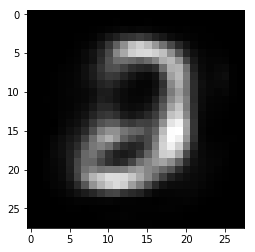

13200 31.7901 22.9602 8.82984


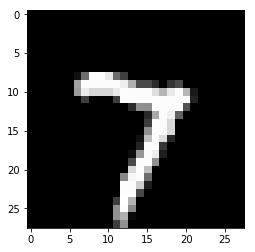

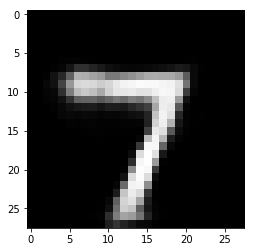

13400 30.2863 20.9029 9.38341


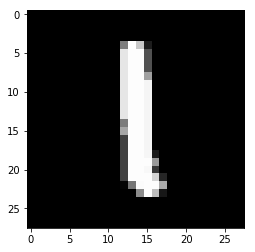

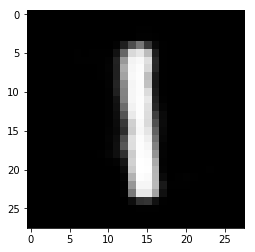

13600 33.041 24.311 8.73007


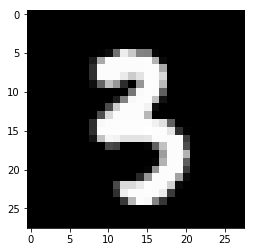

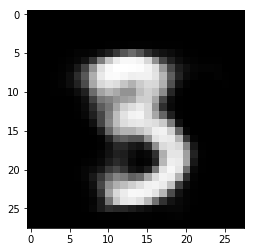

13800 31.5174 22.5826 8.93484


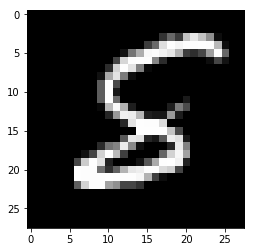

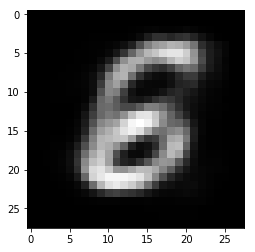

14000 31.7442 22.2618 9.4824


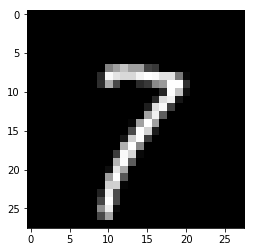

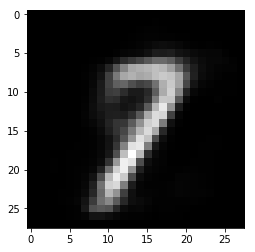

14200 31.9815 22.4295 9.55205


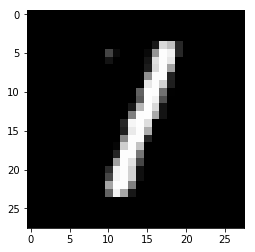

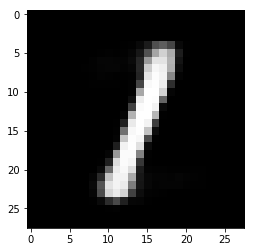

14400 32.038 22.5464 9.49164


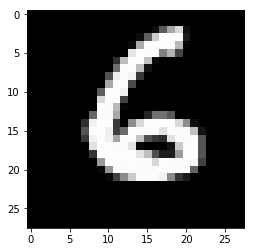

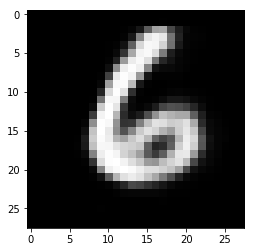

14600 29.3028 19.7641 9.53864


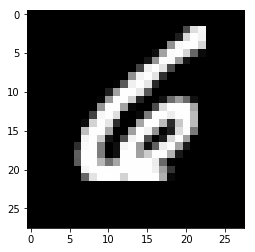

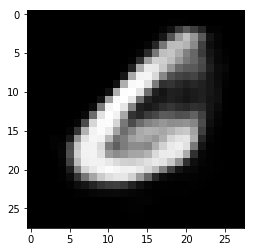

14800 31.1241 21.8019 9.32223


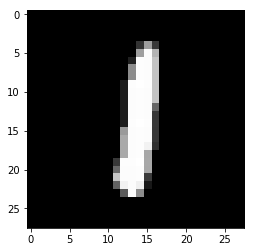

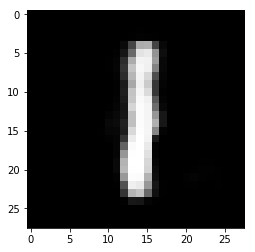

15000 31.9307 22.632 9.29863


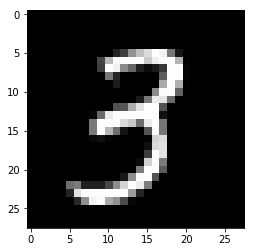

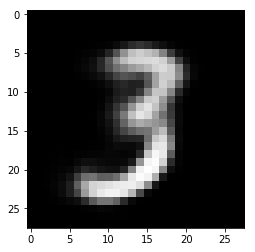

15200 30.4829 21.0331 9.44982


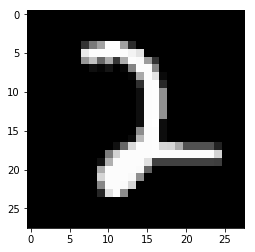

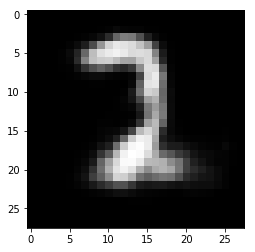

15400 31.9242 22.5664 9.35788


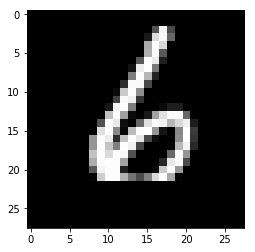

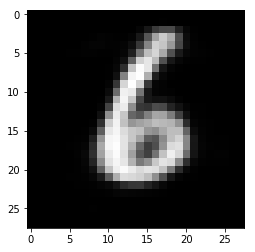

15600 30.397 21.5319 8.86504


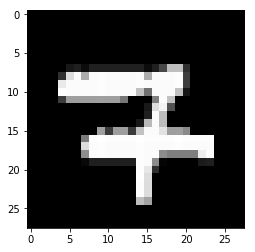

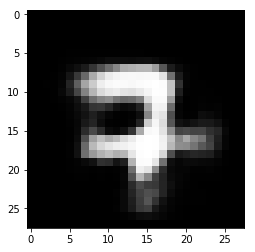

15800 32.9176 23.4543 9.46329


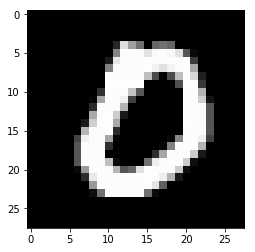

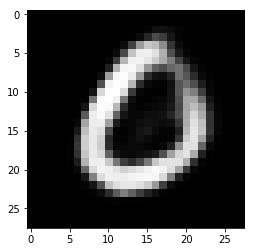

16000 28.8436 20.3197 8.52389


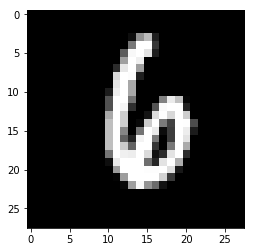

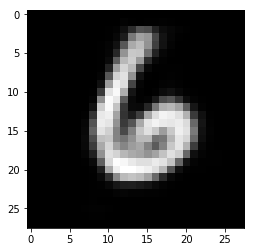

16200 33.1856 23.8933 9.29234


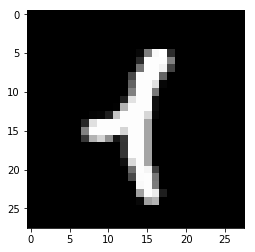

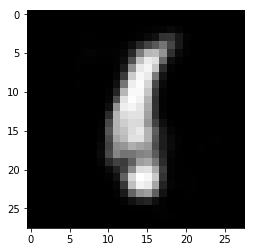

16400 28.7942 19.5753 9.21888


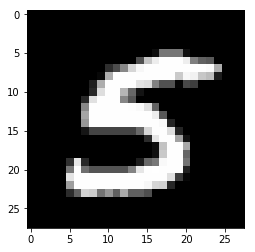

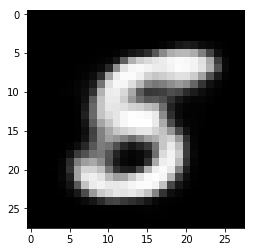

16600 32.0124 22.5973 9.41508


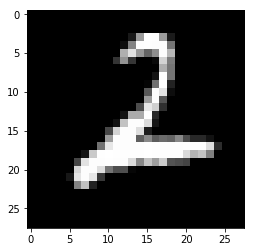

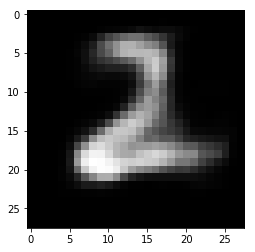

16800 31.922 22.3765 9.54546


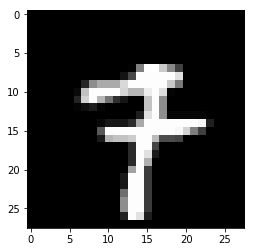

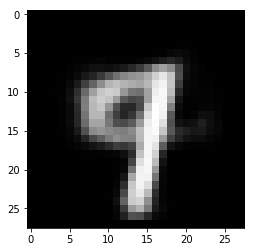

17000 28.3924 19.5779 8.8145


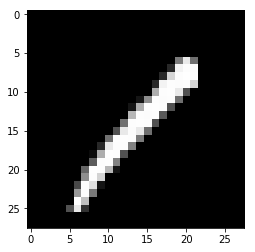

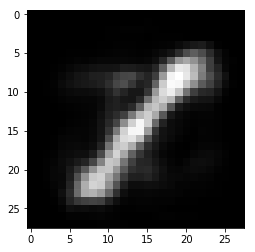

17200 30.4852 21.4858 8.99936


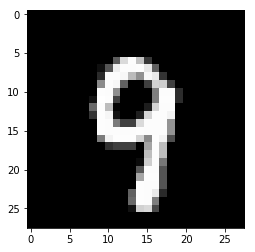

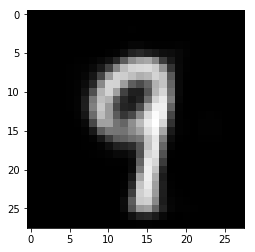

17400 31.8795 22.4417 9.43777


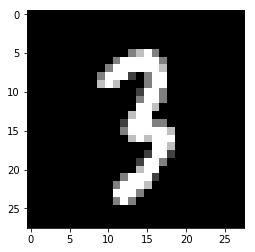

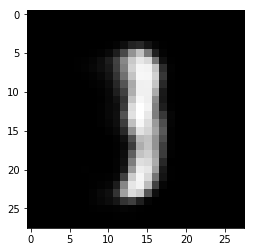

17600 33.0297 24.16 8.86971


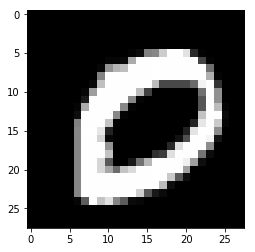

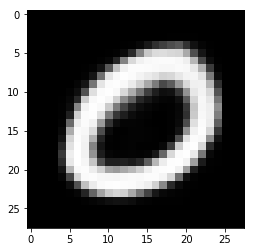

17800 31.6433 22.0698 9.57344


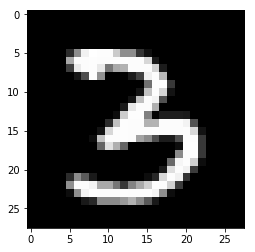

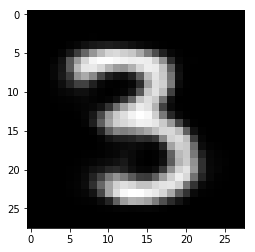

18000 31.4526 22.8983 8.55431


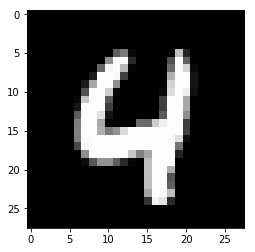

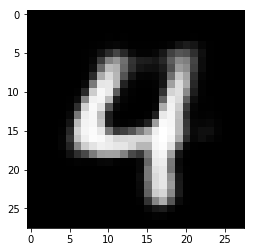

18200 31.921 22.5392 9.38182


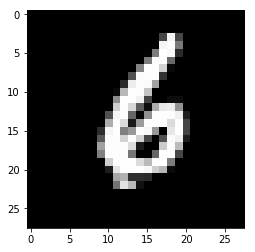

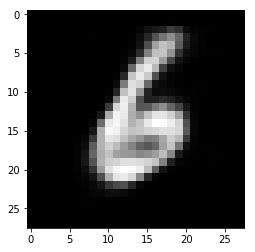

18400 32.0964 22.4318 9.66461


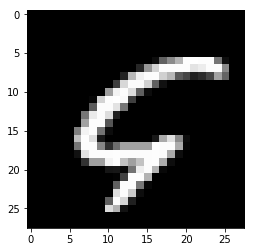

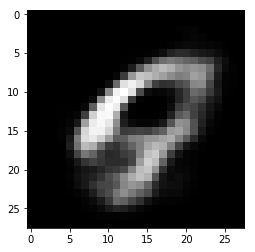

18600 32.6602 23.2953 9.36491


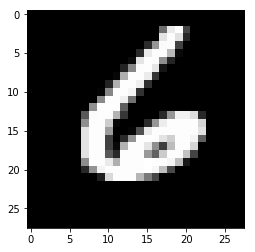

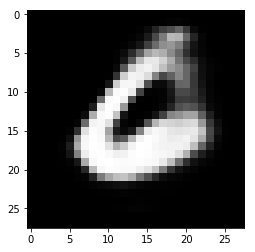

18800 32.8776 23.1125 9.76517


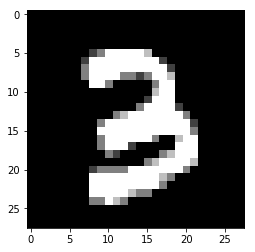

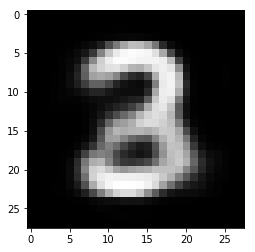

19000 31.5769 22.2528 9.32401


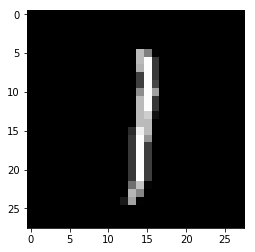

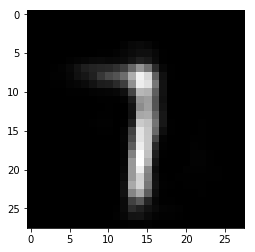

19200 32.3257 23.2321 9.09357


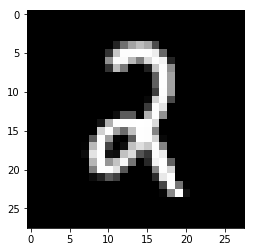

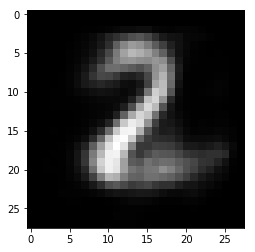

19400 29.5004 19.816 9.68443


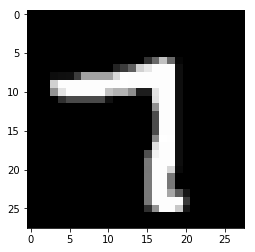

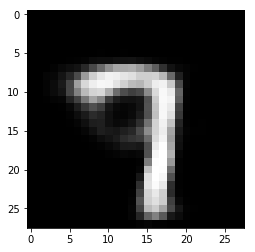

19600 30.8615 20.9711 9.89036


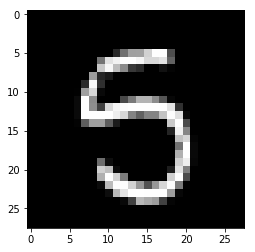

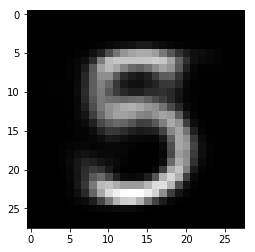

19800 28.6927 19.6765 9.01622


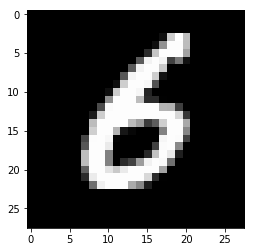

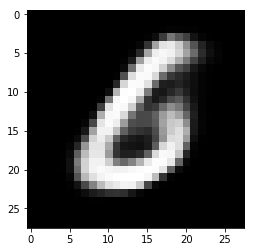

20000 32.4045 23.1969 9.20766


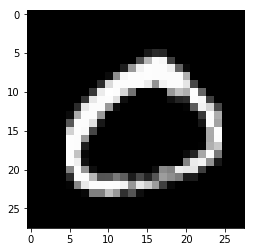

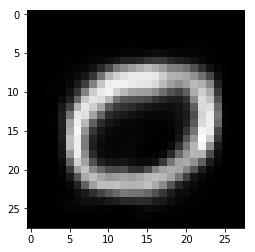

20200 34.5089 24.664 9.84496


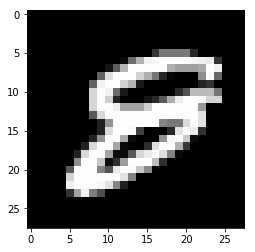

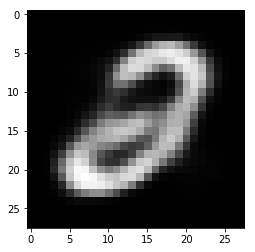

20400 31.583 22.431 9.15195


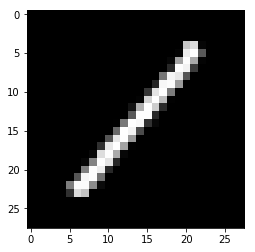

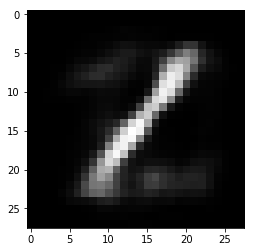

20600 30.906 21.9014 9.00461


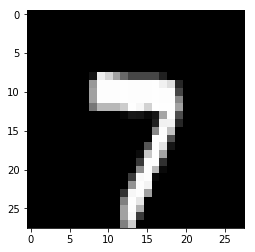

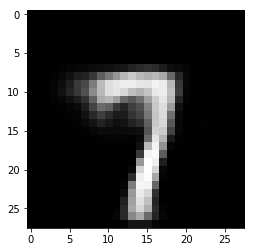

20800 29.4152 19.9747 9.44051


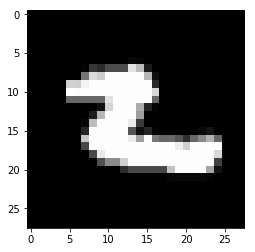

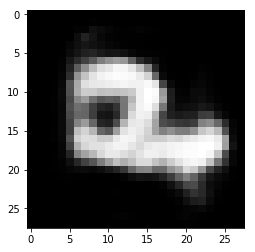

21000 31.6014 22.0242 9.57718


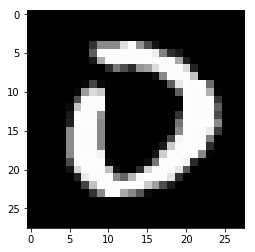

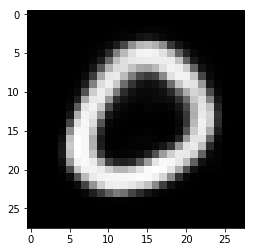

21200 32.887 23.2878 9.59915


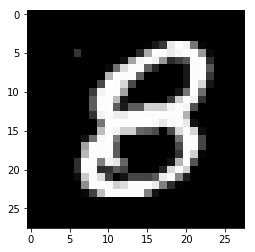

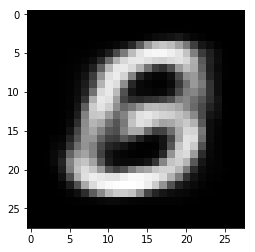

21400 31.5419 22.2783 9.26362


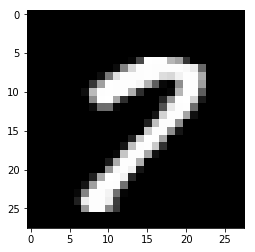

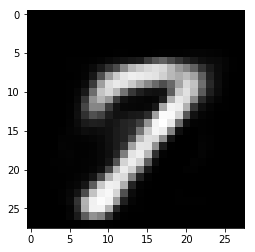

21600 32.1223 22.0944 10.0279


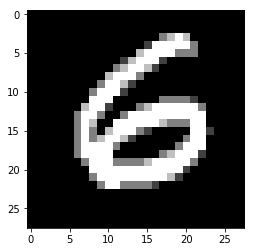

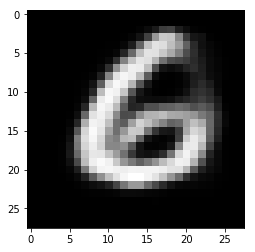

21800 30.1512 20.5186 9.63262


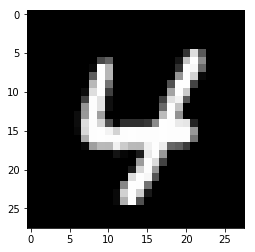

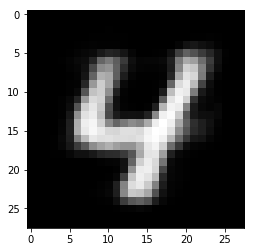

22000 30.8606 21.8682 8.99238


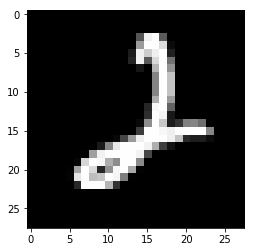

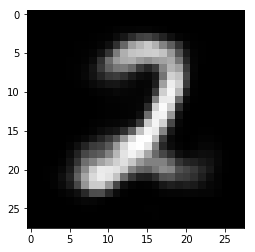

22200 30.1685 20.8298 9.33872


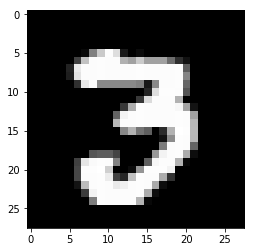

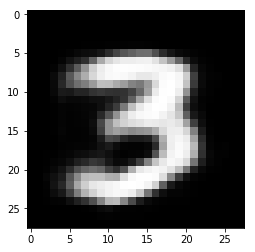

22400 30.7787 21.3381 9.4406


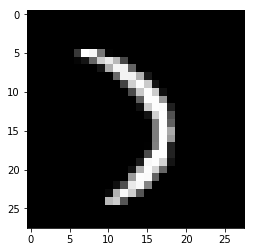

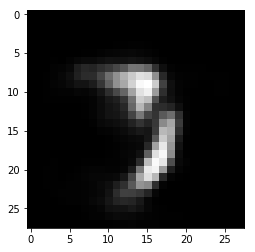

22600 31.3221 22.3989 8.92324


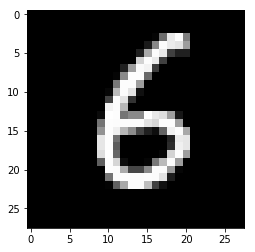

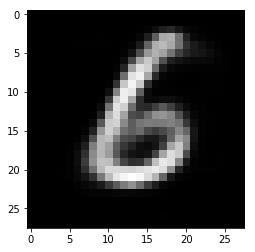

22800 30.0468 20.8623 9.18457


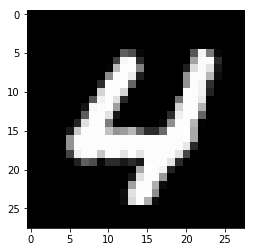

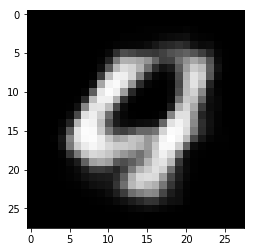

23000 30.0931 20.6122 9.48082


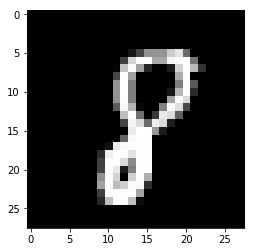

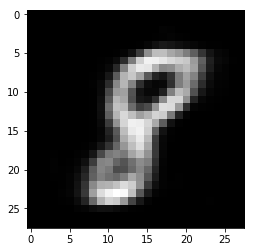

23200 28.0083 19.2368 8.77158


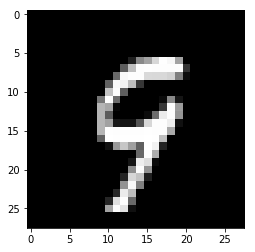

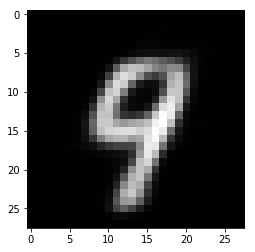

23400 32.5915 22.7918 9.7997


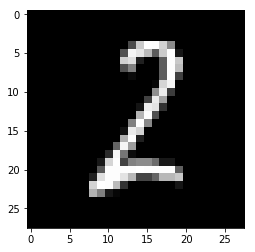

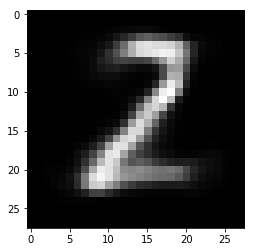

23600 30.6817 21.2892 9.39252


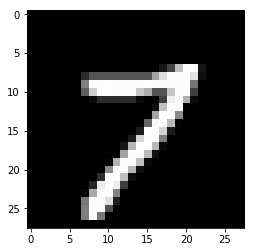

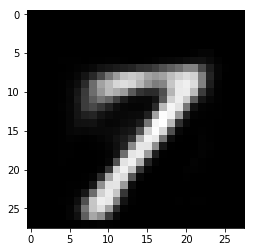

23800 31.437 22.3712 9.06587


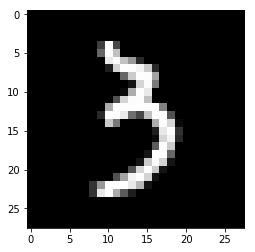

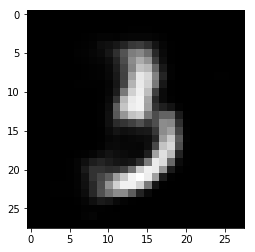

24000 29.8118 20.6313 9.18056


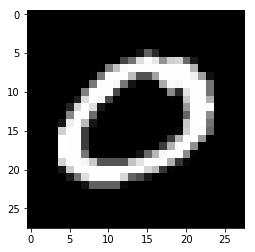

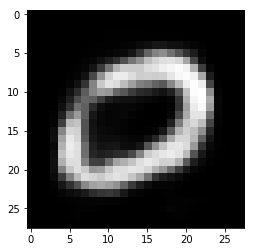

25200 30.8483 21.3175 9.53084


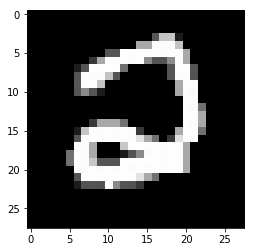

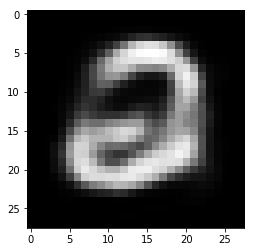

25400 29.3975 19.8434 9.55402


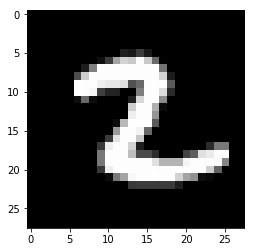

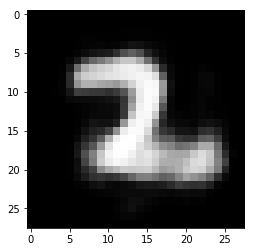

25600 29.7228 19.9173 9.80546


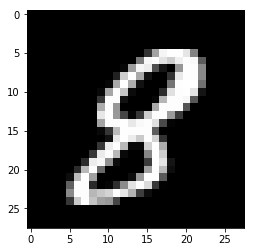

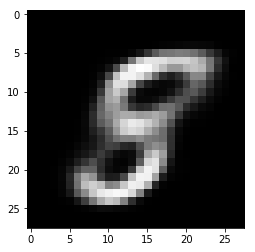

25800 30.1956 21.0086 9.187


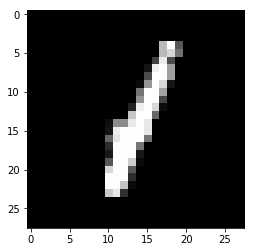

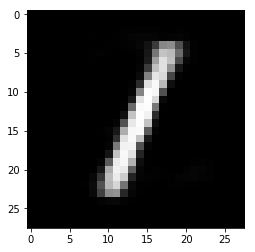

26000 30.6342 20.6287 10.0054


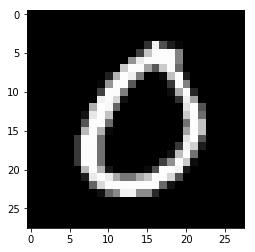

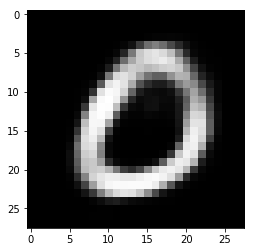

26200 31.2953 21.7372 9.55811


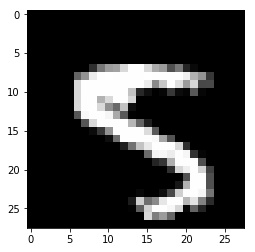

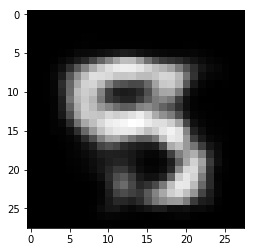

26400 30.1309 20.7218 9.40912


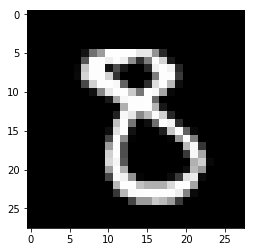

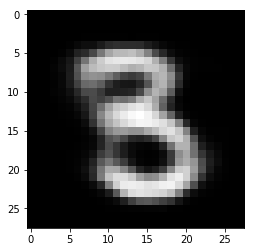

26600 29.6988 20.2939 9.40489


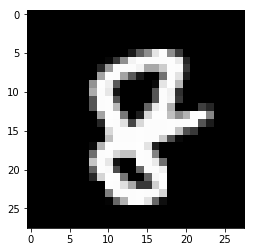

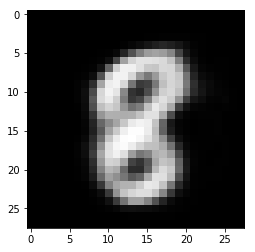

26800 30.6195 21.1994 9.42005


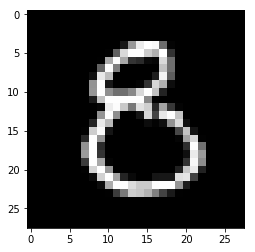

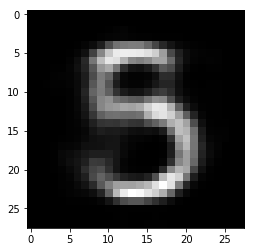

27000 31.1428 22.0631 9.07962


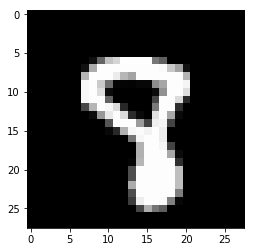

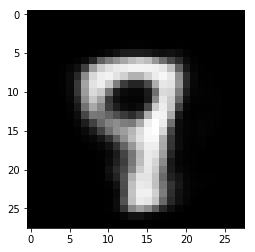

27200 28.9973 19.7738 9.22351


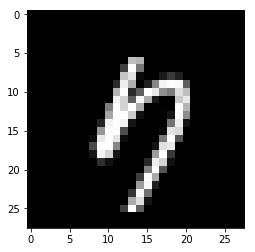

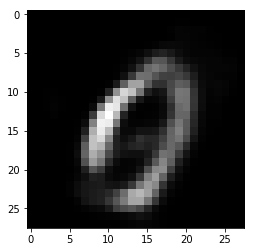

27400 30.582 20.8328 9.7492


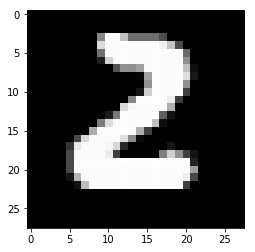

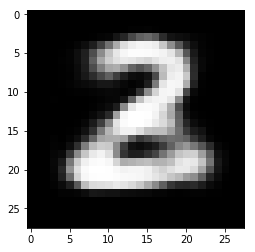

27600 30.7693 20.9702 9.79913


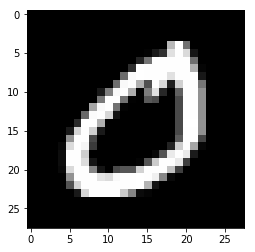

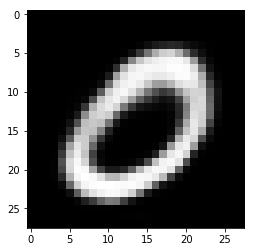

27800 28.1552 18.8033 9.35198


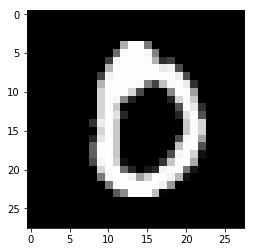

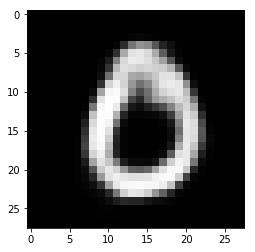

28000 30.3554 20.7588 9.59664


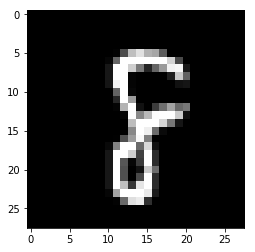

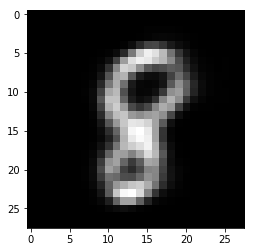

28200 30.5481 21.3902 9.15792


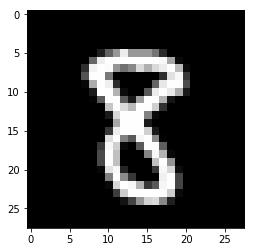

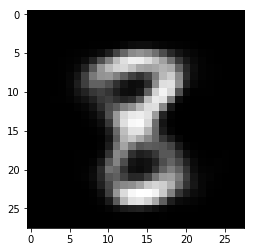

28400 31.3818 21.5982 9.7837


In [ ]:
for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    batch = np.array(batch).reshape((len(batch),28,28,1))
    sess.run(optimizer, feed_dict = {X_ph: batch, Y_ph: batch, keep_prob_ph: 0.8})
    # print(i)
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_ph: batch, Y_ph: batch, keep_prob_ph: 1.0})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0].reshape([28,28]), cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))